# <img src="https://img.icons8.com/bubbles/100/000000/3d-glasses.png" style="height:50px;display:inline"> EE 046746 - Technion - Computer Vision

#### Dahlia Urbach

## Tutorial 04 - Edge and Line Detection
---
<img src=".\assets\LineDetection.png" style="width:400px">

* <a href="https://towardsdatascience.com/tutorial-build-a-lane-detector-679fd8953132">Image source</a>

### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---
* [Why Do We Need Edge Detection?](#-Corners-For-Features,-Edges-For-What?)
* [Edge Detection](#-Edge-Detection-Goal)
    * [Canny Edge Detection](#-The-Canny-Edge-Detector)
    * [Non-Maximum Suppression (NMS)](#-Non-Maximum-Suppression-(NMS))
* [Line Fitting](#-Line-Fitting)
    * [Hough Transform](#-The-Hough-Transform)
    * [RANSAC](#-RANSAC)
    * [SCNN](#-CNNs-for-Line-Detection)
* [Recommended Videos](#-Recommended-Videos)
* [Credits](#-Credits)

In [2]:
# imports for the tutorial
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from scipy import signal
%matplotlib inline

In [3]:
# plot images function
def plot_images(image_list, title_list, subplot_shape=(1,1), axis='off', fontsize=30, figsize=(4,4), cmap=['gray']):
    plt.figure(figsize=figsize)
    for ii, im in enumerate(image_list):
        c_title = title_list[ii]
        if len(cmap) > 1:
            c_cmap = cmap[ii]
        else:
            c_cmap = cmap[0]
        plt.subplot(subplot_shape[0], subplot_shape[1],ii+1)
        plt.imshow(im, cmap=c_cmap)
        plt.title(c_title, fontsize=fontsize)
        plt.axis(axis)

## <img src="https://img.icons8.com/nolan/64/edge-level.png" style="height:50px;display:inline"> Corners For Features, Edges For What?
---

* We know edges are special
* Human visual system is based on edges
* Given an image that contains only edges we can identify objects without any additional information
    
<img src=".\assets\edge0.JPG" style="height:300px">

## <img src="https://img.icons8.com/nolan/64/edge-level.png" style="height:50px;display:inline"> Edge Detection Goal
---
* **Goal**: Map image from 2d array of pixels to a set of curves, line segments, or contours.
    * Most semantic and shape information from the image can be encoded in the edges
    * A more compact representation than a complete image 
* **Ideal**: Artist’s Line drawing (but artists use prior knowledge)


<img src="./assets/edge4.png" style="height:200px">

####  <img src="https://img.icons8.com/nolan/64/edge-level.png" style="height:30px;display:inline"> What can cause an edge?
---
<img src=".\assets\edgeKetch.jpg" style="height:300px">


<img src=".\assets\edgeKetch1.JPG" style="height:300px">

### <img src="https://img.icons8.com/nolan/64/edge-level.png" style="height:50px;display:inline"> Derivatives and Edges
---
* An edge is a place of rapid change in the image intensity function.

<img src=".\assets\derive1.JPG" style="height:300px">

#### <img src="https://img.icons8.com/nolan/64/edge-level.png" style="height:50px;display:inline"> Image Gradient
---
* The gradient of an image: $\nabla f= [\frac{\partial f}{\partial x},\frac{\partial f}{\partial y}]$
* The gradient points in the direction of most rapid change in intensity 

<img src=".\assets\derive2.JPG" style="height:100px">

* The gradient direction (orientation of edge normal) is given by: $\theta = tan^{-1} (\frac{\partial f}{\partial y}/\frac{\partial f}{\partial x})$

* The edge strength is given by the gradient magnitude
$||\nabla f|| = \sqrt {(\frac{\partial f}{\partial y})^2+(\frac{\partial f}{\partial x})^2}$


####  <img src="https://img.icons8.com/nolan/64/edge-level.png" style="height:50px;display:inline"> Differentiation and Convolution
---
* For 2D function, f(x,y), the partial derivative is:
$$\frac{\partial f(x,y)}{\partial x} = lim_{\epsilon \rightarrow 0}\frac{f(x+\epsilon,y)-f(x,y)}{\epsilon}$$

* For discrete data, we can approximate using finite differences:
$$\frac{\partial f(x,y)}{\partial x} = \frac{f(x+1,y)-f(x,y)}{\Delta x}$$

* To implement above as convolution, what would be the associated filter?

<img src=".\assets\derive4.png" style="height:50px">


#### <img src="https://img.icons8.com/nolan/64/edge-level.png" style="height:50px;display:inline"> Assorted Finite Difference Filters
---
<img src=".\assets\derive5.png" style="height:200px">

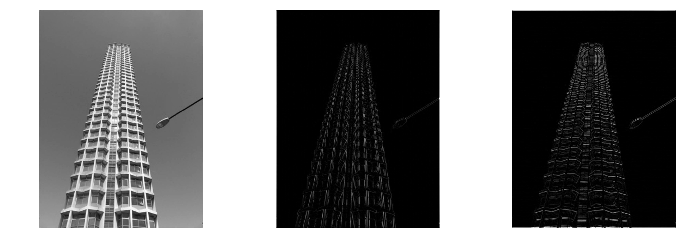

In [4]:
im = cv2.imread('assets/sobel_bulding.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
ksize = 3
im_x = np.abs(cv2.Sobel(im, cv2.CV_64F, 1, 0, ksize=ksize))
im_y = np.abs(cv2.Sobel(im, cv2.CV_64F, 0, 1, ksize=ksize))

plot_images([im,im_x,im_y], ['','',''], subplot_shape=(1,3), figsize=(12,4))

* Which show changes with respect to $x$? $y$?

#### <img src="https://img.icons8.com/nolan/64/edge-level.png" style="height:50px;display:inline">  Effects of Noise
---
* Consider a single row or column of the image
* Plotting intensity as a function of position gives a signal:

<img src=".\assets\derive7.JPG" style="height:200px">

* Where is the edge?


* Finite difference filters respond strongly to noise
    * Image noise results in pixels that look very different from their neighbors
    * Generally, the larger the noise the stronger the response

* What can be done?




* Smoothing the image should help! – it forces pixels to look more like their neighbors

#### <img src="https://img.icons8.com/nolan/64/edge-level.png" style="height:50px;display:inline"> Solution:  Smooth First
---
<img src=".\assets\derive8.JPG" style="height:250px">

* Where is the edge?
    * Look for peaks in $\frac{\partial}{\partial x}(f*g)$

#### <img src="https://img.icons8.com/nolan/64/edge-level.png" style="height:50px;display:inline"> Derivative Theorem of Convolution
---
Differentiation property of convolution:   $\frac{\partial}{\partial x}(f*g) = f *\frac{\partial}{\partial x}g$

<img src=".\assets\derive9.JPG" style="height:250px">


#### <img src="https://img.icons8.com/nolan/64/edge-level.png" style="height:50px;display:inline"> Derivative of Gaussian Filter
---
* Is this a separable filter?

<img src=".\assets\derive10.JPG" style="height:200px">

* Yes, we can split it into two filters in which their order does not matter
* Median is a non-separable filter

#### <img src="https://img.icons8.com/nolan/64/edge-level.png" style="height:50px;display:inline"> Derivative of Gaussian Filter
---
<img src=".\assets\derive11.JPG" style="height:200px">

* Which one finds horizontal/vertical edges?

#### <img src="https://img.icons8.com/nolan/64/edge-level.png" style="height:50px;display:inline"> Smoothing Tradeoffs
---
<img src=".\assets\derive12.jpg" style="height:200px">

* Smoothed derivative removes noise, but blurs edge.  
    * Also finds edges at different “scales”.

#### <img src="https://img.icons8.com/nolan/64/edge-level.png" style="height:50px;display:inline"> Laplacian of Gaussian (LoG)
---
<img src=".\assets\derive13.JPG" style="height:300px">

* Where is the edge?
    * Zero-crossings of bottom graph

#### <img src="https://img.icons8.com/nolan/64/edge-level.png" style="height:50px;display:inline"> 2D Edge Detection Filters
---
<img src=".\assets\derive14.JPG" style="height:300px">


#### <img src="https://img.icons8.com/nolan/64/edge-level.png" style="height:50px;display:inline"> DoG: Difference of Gaussians
---
* Can approximate Laplacian filter

<img src=".\assets\derive15.JPG" style="height:300px">

###  <img src="https://img.icons8.com/doodle/48/000000/ok.png" style="height:50px;display:inline"> What is a Good Edge Detector?
---
* Good detection:
    * Minimize false positives (wrong detections)
    * Minimize false negatives (missing real edges)
    * Maximize true detections
* Good localization:
    * Detected edges should be as close as possible to the true edges
* Single response:
    * Return a single detection for each true edge point
* Connect detections to lines

<img src=".\assets\derive16.jpg.png" style="height:150px">

* Which of these detections is the best?

####  <img src="https://img.icons8.com/flat_round/64/000000/bar-chart--v1.png" style="height:50px;display:inline"> What Are the Parameters?
---
* <font color='red'>Scale</font>
* Threshold


#### Scale Selection
---
* Recall: We first smooth the image with a Gaussian kernel to reduce noise.
* The scale of the Gaussian determines how much smoothing we apply

<img src=".\assets\derive17.JPG" style="height:150px">

####  Effect of $\sigma$ On Derivatives
---
* The apparent structures differ depending on Gaussian’s scale parameter.
* Large scale: larger scale edges detected
* Small scale: finer features detected

<img src=".\assets\derive18.JPG" style="height:150px">

#### How Do We Choose the Scale?
---
* It depends what we’re looking for:
<img src=".\assets\derive19.jpg" style="height:150px">

* Too fine of a scale…
    * Can’t see the forest for the trees.
* Too coarse of a scale…
    * Can’t tell the maple grain from the cherry.

#### <img src="https://img.icons8.com/flat_round/64/000000/bar-chart--v1.png" style="height:50px;display:inline"> What Are the Parameters?
---
* Scale
* <font color='red'>Threshold</font>

####  Thresholding
---
* Choose a threshold value 
* Set any pixels less than thresh to zero (off)
* Set any pixels greater than or equal to thresh to one (on)

In [5]:
im_o = cv2.imread('./assets/buttefly.png')
im = cv2.cvtColor(im_o, cv2.COLOR_BGR2GRAY)
ksize = 5

# blur image
im = cv2.GaussianBlur(im, (ksize, ksize), 0)

# edge extraction:
k_x = np.array([[0, 1, 0], [0, 0, 0], [0, -1, 0]])
k_y = np.array([[0, 0, 0], [-1, 0, 1], [0, 0, 0]])
im_x = cv2.filter2D(im, cv2.CV_64F, k_x)
im_y = cv2.filter2D(im, cv2.CV_64F, k_y)

# gradient magnitude:
im_grad_mag = np.sqrt(np.square(im_x) + np.square(im_y))

low_thresh = im_grad_mag > 7 # low threshold
high_thresh = im_grad_mag > 30 # High threshold

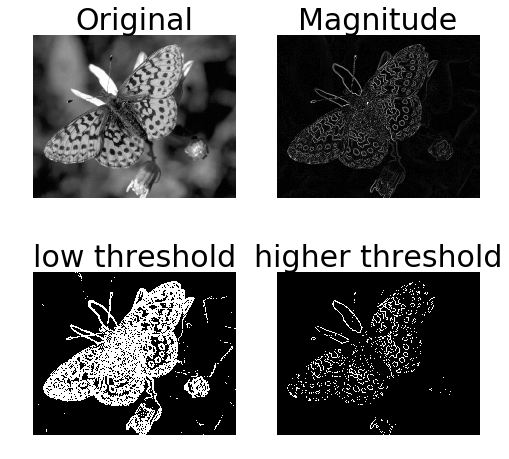

In [6]:
# figures:
plot_images([im, im_grad_mag, low_thresh, high_thresh], ['Original', 'Magnitude', 'low threshold', 'higher threshold'],
            subplot_shape=(2,2), figsize=(8,8))

## <img src="https://img.icons8.com/carbon-copy/100/000000/squiggly-line.png" style="height:50px;display:inline"> The Canny Edge Detector
---
* Probably the most widely used edge detector in Computer Vision

* Key idea: Detect step-edges that are corrupted by additive Gaussian noise

* Theorem: Canny has shown that the first derivative of the Gaussian closely approximates the operator that optimizes the product of signal-to-noise ratio and localization

 
* <a href="https://scholar.google.com/scholar?cluster=6445737130860653197&hl=en&as_sdt=0,5&sciodt=0,5">J. Canny, A Computational Approach To Edge Detection, IEEE Trans. Pattern Analysis and Machine Intelligence, 8:679--‐714, 1986.</a>
    * 34189 citations until today!


#### <img src="https://img.icons8.com/carbon-copy/100/000000/squiggly-line.png" style="height:50px;display:inline"> The Canny Edge Detector - Building Blocks
---
* Filter image with derivative of Gaussian 
* Find magnitude and orientation of gradient
* Non-maximum suppression: <font color='red'>(Localization)</font>                      
    * Thin multi-pixel wide “ridges” down to single pixel width
* Linking and thresholding (hysteresis): <font color='red'>(Linking)</font>
    * Define two thresholds: low and high
    * Use the high threshold to start edge curves and the low threshold to continue them
    
* In OpenCV: `cv2.Canny()`

#### <img src="https://img.icons8.com/carbon-copy/100/000000/squiggly-line.png" style="height:50px;display:inline"> Canny Example - Input
---

In [7]:
# Load Image
img = cv2.imread('./assets/tut_panda.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
in_x_min = 100
in_x_max = 400
in_y_min = 300
in_y_max = 700
gray_cut = gray[in_y_min:in_y_max, in_x_min:in_x_max]

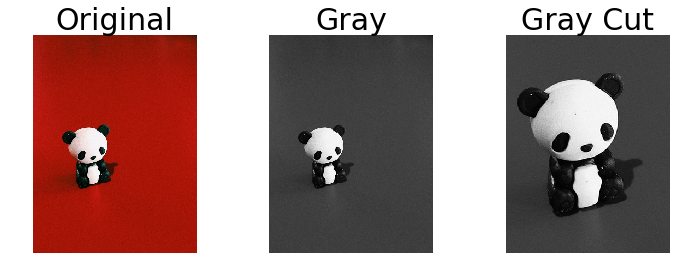

In [8]:
plot_images([img_rgb, gray, gray_cut], ['Original', 'Gray', 'Gray Cut'], cmap=[None, 'gray', 'gray'],
            subplot_shape=(1, 3), figsize=(12, 4))

* Photo by <a href="https://unsplash.com/@pgonzalez_95?utm_medium=referral&amp;utm_campaign=photographer-credit&amp;utm_content=creditBadge/">Pedro  Gonzalez</a> from <a href="https://unsplash.com/
">Unsplash</a>

#### <img src="https://img.icons8.com/carbon-copy/100/000000/squiggly-line.png" style="height:50px;display:inline"> Canny Example - Step 1 - Blur
---

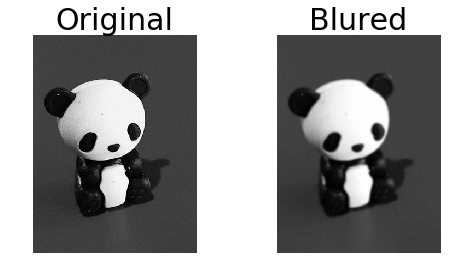

In [9]:
# Gaussian Blurring
blur = cv2.GaussianBlur(gray_cut, (9,9), 0)
plot_images([gray_cut, blur], ['Original','Blured'], cmap=['gray', 'gray'], subplot_shape=(1,2), figsize=(8,4))

#### <img src="https://img.icons8.com/carbon-copy/100/000000/squiggly-line.png" style="height:50px;display:inline"> Canny Example - Step 2 - Find Magnitude and Orientation of Gradient
---

In [10]:
# Apply Sobel:
sobelx_64 = cv2.Sobel(blur, cv2.CV_64F, 1, 0, ksize=3)
sobely_64 = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=3)
 
# From gradients calculate the magnitude and changing
mag = np.hypot(sobelx_64, sobely_64)
mag = mag / mag.max()
 
# Find the direction and change it to degree
theta = np.arctan2(sobely_64, sobelx_64)
angle = np.rad2deg(theta)

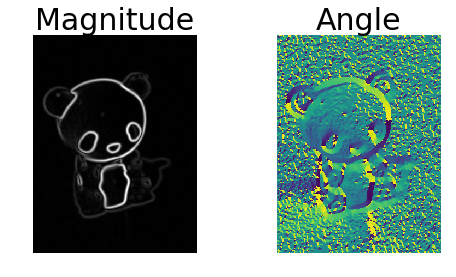

In [11]:
plot_images([mag, angle], ['Magnitude', 'Angle'], subplot_shape=(1,2), figsize=(8,4), cmap=['gray', None])

#### <img src="https://img.icons8.com/carbon-copy/100/000000/squiggly-line.png" style="height:50px;display:inline"> Canny Example - Step 3 - Localization
---
* How to turn these thick regions of the gradient into curves?

<img src=".\assets\canyy_e.png" style="height:200px">

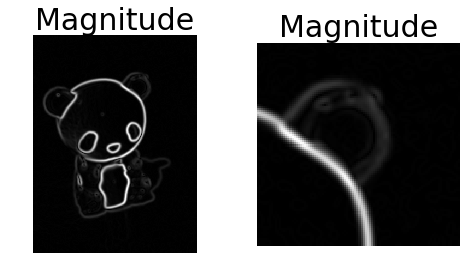

In [12]:
in_x_min, in_x_max, in_y_min, in_y_max = (150, 250, 50, 150)
mag_cut = mag[in_y_min:in_y_max, in_x_min:in_x_max]
plot_images([mag, mag_cut], ['Magnitude','Magnitude'], subplot_shape=(1,2), figsize=(8,4))

#### <img src="https://img.icons8.com/carbon-copy/100/000000/squiggly-line.png" style="height:50px;display:inline"> Non-Maximum Suppression (NMS)
---
* Check if pixel is local maximum along gradient direction, select single max across width of the edge
* Requires checking interpolated pixels $p$ and $r$

<img src=".\assets\non-max.JPG" style="height:200px">

In [13]:
# Find the neighbouring pixels (b,c) in the rounded gradient direction
# and then apply non-max suppression
M, N = mag.shape
Non_max = np.zeros((M,N), dtype= np.float64)
 
for i in range(1,M-1):
    for j in range(1,N-1):
       # Horizontal 0
        if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180) or (-22.5 <= angle[i,j] < 0)\
        or (-180 <= angle[i,j] < -157.5):
            b = mag[i, j+1]
            c = mag[i, j-1]
        # Diagonal 45
        elif (22.5 <= angle[i,j] < 67.5) or (-157.5 <= angle[i,j] < -112.5):
            b = mag[i+1, j+1]
            c = mag[i-1, j-1]
        # Vertical 90
        elif (67.5 <= angle[i,j] < 112.5) or (-112.5 <= angle[i,j] < -67.5):
            b = mag[i+1, j]
            c = mag[i-1, j]
        # Diagonal 135
        elif (112.5 <= angle[i,j] < 157.5) or (-67.5 <= angle[i,j] < -22.5):
            b = mag[i+1, j-1]
            c = mag[i-1, j+1]           
            
        # Non-max Suppression
        if (mag[i,j] >= b) and (mag[i,j] >= c):
            Non_max[i,j] = mag[i,j]
        else:
            Non_max[i,j] = 0

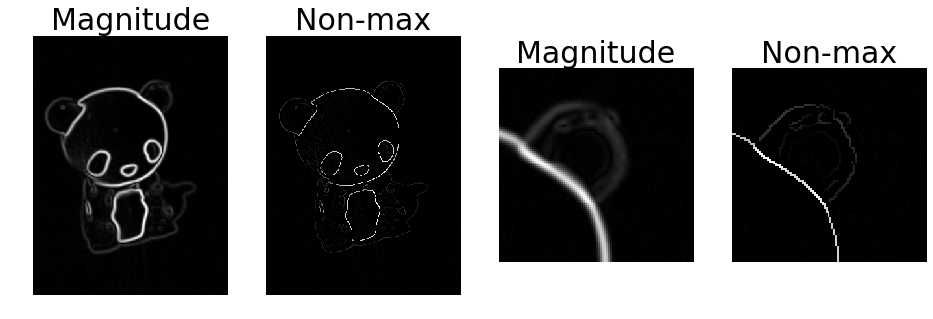

In [14]:
mag_cut = mag[in_y_min:in_y_max, in_x_min:in_x_max]
Non_max_cut = Non_max[in_y_min:in_y_max, in_x_min:in_x_max]
plot_images([mag, Non_max, mag_cut, Non_max_cut], ['Magnitude', 'Non-max', 'Magnitude', 'Non-max'],
            subplot_shape=(1,4), figsize=(16,8))

#### <img src="https://img.icons8.com/carbon-copy/100/000000/squiggly-line.png" style="height:50px;display:inline"> Canny Example - Step 4 - Edge Linking
---
* Assume the marked point is an edge point.
* Then we construct the tangent to the edge curve (which is normal to the gradient at that point) and use this to predict the next points (here either $r$ or $s$).

<img src=".\assets\canyy_h.png" style="height:200px">

#### <img src="https://img.icons8.com/carbon-copy/100/000000/squiggly-line.png" style="height:50px;display:inline"> Hysteresis Thresholding
---
* Check that maximum value of gradient value is sufficiently large
    * Drop-outs? Use hysteresis
        * Use a high threshold to start edge curves and a low threshold to continue them.
        
<img src=".\assets\canyy_j.png" style="width:400px">

In [15]:
# Hysterasis - step 1 - two tresholds
# Set high and low threshold
highThreshold = 40 / 255
lowThreshold = 10 / 255
 
M, N = Non_max.shape
out = np.zeros((M,N), dtype= np.float64)
 
# If edge intensity is greater than 'High' it is a sure-edge
# below 'low' threshold, it is a sure non-edge
strong_i, strong_j = np.where(Non_max >= highThreshold)
zeros_i, zeros_j = np.where(Non_max < lowThreshold)
 
# weak edges
weak_i, weak_j = np.where((Non_max <= highThreshold) & (Non_max >= lowThreshold))
 
# Set same intensity value for all edge pixels
out[strong_i, strong_j] = 255
out[zeros_i, zeros_j ] = 0
out[weak_i, weak_j] = 75

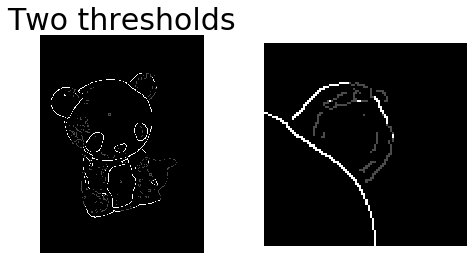

In [16]:
plot_images([out, out[in_y_min:in_y_max, in_x_min:in_x_max]], ['Two thresholds', ''],
            subplot_shape=(1,2), figsize=(8,4))

#### Linking edges

In [17]:
# Hysterasis - step 2
out1 = np.copy(out)
new_points = []
M, N = out1.shape
for i in range(1, M-1):
    for j in range(1, N-1):
        if (out1[i,j] == 75):
            # 8 nieghbors search:
            if 255 in [out1[i+1, j-1], out1[i+1, j], out1[i+1, j+1], out1[i, j-1], out1[i, j+1],
                       out1[i-1, j-1], out1[i-1, j], out1[i-1, j+1]]:
                out1[i, j] = 255
                new_points.append(np.array([i,j]))
            else:
                out1[i, j] = 0                           
new_points = np.stack(new_points,-1)

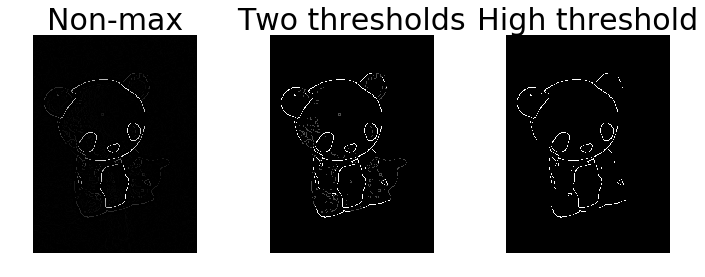

In [29]:
# Hysterasis output
plot_images([Non_max, out, out > 75], ['Non-max', 'Two thresholds', 'High threshold'], subplot_shape=(1,3), figsize=(12,4))

(-0.5, 299.5, 399.5, -0.5)

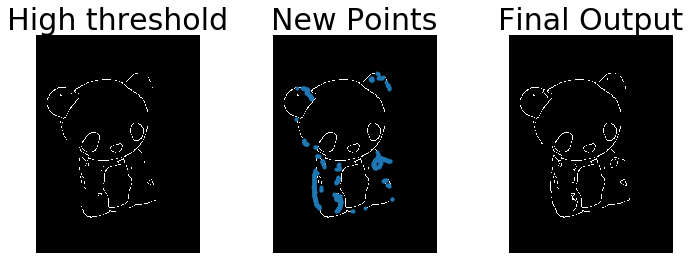

In [20]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(out > 75,cmap='gray')
plt.title('High threshold',fontsize=30)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(out1,cmap='gray')
plt.title('New Points',fontsize=30)
plt.plot(new_points[1],new_points[0],'.')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(out1,cmap='gray')
plt.title('Final Output',fontsize=30)
plt.axis('off')

#### Canny in one line (OpenCV)

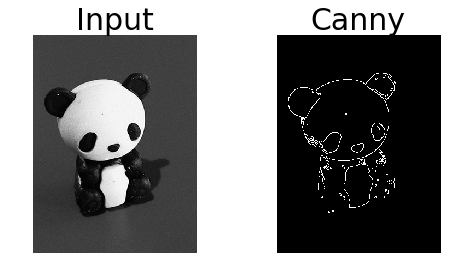

In [27]:
# Canny
im_canny = cv2.Canny(gray_cut, 50, 260)
plot_images([gray_cut, im_canny], ['Input', 'Canny'], subplot_shape=(1,2), figsize=(8,4))

## <img src="https://img.icons8.com/nolan/64/squiggly-line.png" style="height:50px;display:inline"> Line Fitting
---
* Hough Transform
* RANSAC
* SCNN

#### <img src="https://img.icons8.com/nolan/64/squiggly-line.png" style="height:50px;display:inline"> Fitting a Parametric Model to Data
---
* Design questions:
    * What is a good model to represent our data?
    * Do we plan to fit multiple instances?
* Challenges:
    * Which features belong to the model? To which instance?
    * How many instances are there?
    * Computational complexity (typically we cannot examine all possible models).

#### <img src="https://img.icons8.com/nolan/64/squiggly-line.png" style="height:50px;display:inline"> Line Fitting Applications
---
* Detection of power lines in helicopter navigation systems

<img src=".\assets\lines1.png" style="width:400px">

* Image credit: Horev et al. SIAM’15

* Lane detection from car cameras in crash preventing systems

<img src=".\assets\lines2.jpg" style="width:400px">

* Sports

<img src=".\assets\lines3.JPG" style="width:500px">

* “Interactive 3D Architectural Modeling from Unordered Photo Collections” Sinha et al. 2008*

<img src=".\assets\lines4.JPG" style="width:500px">

#### <img src="https://img.icons8.com/ios/50/000000/effort.png" style="height:50px;display:inline"> Challenges of Line Fitting
---
* Not all the lines in the image are continuous

<img src=".\assets\lines5.JPG" style="width:500px">

#### <img src="https://img.icons8.com/ios/50/000000/effort.png" style="height:50px;display:inline"> Challenges of Line Fitting
---
* Which points on which line?
* Noisy edge detection:
    * Clutter
    * Missed parts
    * Points are only approximately along the line
    
<img src=".\assets\lines7.png" style="width:100px">

* Large search space
* How many lines are there?

<img src=".\assets\lines6.png" style="width:150px">

#### Voting
---
* Problem: 
    * We cannot try all possible models
* Solution by voting:
    * Features (points) vote for models they are compatible with
    * Search for models with lots of votes

<img src=".\assets\lines8.JPG" style="width:400px">

### <img src="https://img.icons8.com/nolan/64/rating.png" style="height:50px;display:inline"> The Hough Transform
---
* Transformation from image space $(x,y)$ to Hough space $(m,b)$ 

* A line in the image corresponds to a point in Hough space
    * Image $\rightarrow$ Hough: Given a set of points $(x,y)$ find all $(m,b)$ such that $y=mx+b$
    
<img src=".\assets\lines11.JPG" style="width:400px">

* Hough $\rightarrow$ Image: A point $(x_0,y_0)$ in the image is the solution of $b=−x_0 m+y_0$
    
<img src=".\assets\lines12.JPG" style="width:400px">

* The line that contains both points $(x_0,y_0)$ and $(x_1,y_1)$ is the intersection of the lines $b=−x_0 m+y_0$ and $b=−x_1 m+y_1$
    
<img src=".\assets\lines13.JPG" style="width:400px">

#### <img src="https://img.icons8.com/nolan/64/rating.png" style="height:50px;display:inline"> Finding Lines with the Hough Transform
---
* Each edge point <font color='red'>votes</font> for a set of possible parameters in Hough space
* Count votes in a discrete set of bins
* Parameters with lots of votes indicate lines in image space

<img src=".\assets\lines14.JPG" style="width:400px">

#### <img src="https://img.icons8.com/nolan/64/rating.png" style="height:50px;display:inline"> Polar Representation for Lines
---

* Problem: The familiar line equation $y=mx+b$ is problematic:
    * Can take infinite values $(m,b)$
    * Undefined for vertical lines
    
* Solution: Use polar representaton $$x \cos{\theta}+y\cos{\theta}=d $$ $$\theta \in [0,\pi), d \in R$$

#### <img src="https://img.icons8.com/nolan/64/rating.png" style="height:50px;display:inline"> The Hough-Transform Algorithm
---
* Use polar representaton $x \cos{\theta}+y\cos{\theta}=d ,\: \: \theta \in [0,\pi), d \in R$
* Quantize Hough space

* Loop:
    1. Initialize $H[d,\theta]=0$
    2. For each edge point $(x,y)$ in the image $H[d,\theta]+= 1$
    3. Find bins $H[d,\theta]$ with maximum value

#### <img src="https://img.icons8.com/nolan/64/rating.png" style="height:50px;display:inline"> Hough-Transform Example
---
* For a given point $(x_0,y_0)$

$$d(\theta)=x_0 \cos\theta + y_0 \sin \theta$$

<img src=".\assets\lines15.JPG" style="width:400px">

<img src=".\assets\lines16.JPG" style="width:400px">

#### <img src="https://img.icons8.com/nolan/64/rating.png" style="height:50px;display:inline"> Hough-Transform Properties
---
* Noise and clutter votes are inconsistent, so will not accumulate.
* Can handle occlusions if not all points are present as long as model gets enough votes.
* Efficient.

#### <img src="https://img.icons8.com/nolan/64/rating.png" style="height:50px;display:inline"> Hough-Transform Example on Real Images
---
<img src=".\assets\lines17.JPG" style="width:500px">

* Showing the longest segments found

* <a href="https://youtu.be/u1pZE5VpDAQ">Line detection video</a>
    * <a href="https://towardsdatascience.com/tutorial-build-a-lane-detector-679fd8953132">Video source</a>

#### <img src="https://img.icons8.com/nolan/64/rating.png" style="height:50px;display:inline"> Impact of Noise on Hough Transform
---
* What difficulties does noise introduce?

<img src=".\assets\lines18.png" style="width:400px">

* Here everything is “noise” but we still see peaks in the vote space

<img src=".\assets\lines20.JPG" style="width:400px">

#### <img src="https://img.icons8.com/nolan/64/rating.png" style="height:50px;display:inline"> Voting: Practical Tips
---
* Use only trustworthy points
    * E.g., edges points with significant gradient magnitude (alternatively weight votes)
    * Szeliski suggests using edges instead of points 
* Choose a good quantization grid
    * Not too coarse – too many lines fall in the same bucket
    * Not too fine – collinear points vote for different lines
* Smooth the voting (vote also for neighbors)
* Non-maxima suppression
* Refit line using accumulated votes
* Reduce number of parameters, if possible

#### <img src="https://img.icons8.com/nolan/64/rating.png" style="height:50px;display:inline"> Hough Transform Summary
---
* **Pros**
    * Can handle occlusions
    * Some robustness to noise
    * Can detect multiple lines in a single pass over the image

* **Cons**
    * Complexity increases exponentially with the number of parameters
    * Clutter can produce spurious peaks in parameter space
    * Hard to select the right quantization

#### <img src="https://img.icons8.com/nolan/64/rating.png" style="height:50px;display:inline"> Generalized Hough Transform
---
* Can be extended to other parametric models such as: **circles, ellipses, rectangles** etc.

* Complexity increases exponentially with the number of parameters.

* Can be used to detect complex non-parametric models as described in *Leibe et al.  “Combined object categorization and segmentation with an implicit shape model”*.

## <img src="https://img.icons8.com/dotty/80/000000/line.png" style="height:50px;display:inline"> RANSAC
#### RANdom SAmple Consensus [Fischler & Bolles 1981]
---
* Key ideas:
    * Look for “inliers” and use only them
    * If we fit a model to “outliers” we will not get a good fitting

#### <img src="https://img.icons8.com/dotty/80/000000/line.png" style="height:50px;display:inline">  RANSAC Algorithm
---
*Loop*:

1. Randomly select a group of points
2. Fit a model to the selected group
3. Find the inliers of the computed model
4. If number of inliers is large enough re-compute model using only inliers
5. Compute number of inliers of updated model

**The winner**:  model with the largest number of inliers

#### <img src="https://img.icons8.com/dotty/80/000000/line.png" style="height:50px;display:inline"> Line Fitting with RANSAC
---
* Input: A set of edge points

<img src=".\assets\lines21.png" style="width:300px">

* **Step 1**: Select two points

<img src=".\assets\lines22.png" style="width:300px">

* **Step 2**: Fit a line to the selected points

<img src=".\assets\lines23.png" style="width:300px">

* **Step 3**: Identify inliers

<img src=".\assets\lines24.png" style="width:300px">

* **Step 4**: Fit line to inliers

<img src=".\assets\lines25.png" style="width:300px">

* **Step 5**: Count number of new inliers

<img src=".\assets\lines26.png" style="width:300px">

#### <img src="https://img.icons8.com/dotty/80/000000/line.png" style="height:50px;display:inline"> RANSAC – Stopping Criteria
---
* **Option 1**:  when the model is good enough:
    * By the number of inliers
    * By its fitting error

* **Option 2**: according to probability
    * Let $K$ be the number of iterations
    * Let $n$ be the number of points needed to compute the model
    * Let $f$ be the fraction of inliers of a model
    * Then the probability that a single sample is correct:   $f^n$
    * The probability that all $K$ samples fail is  $(1−f^n)^K$
    * Choose $K$ high enough to keep the failure rate low enough

#### <img src="https://img.icons8.com/dotty/80/000000/line.png" style="height:50px;display:inline"> RANSAC – For Multiple Models?
---
* How can we use RANSAC to compute multiple models?
    * Apply RANSAC multiple times, each time we remove the detected inliers.

#### <img src="https://img.icons8.com/dotty/80/000000/line.png" style="height:50px;display:inline"> RANSAC - Summary
---
* **Pros**
    * General method that works well for lots of model fitting problems
    * Easy to implement

* **Cons**
    * When the percentage of outliers is high too many iterations are needed and failure rate increases    

### <img src="https://img.icons8.com/dusk/64/000000/artificial-intelligence.png" style="height:50px;display:inline"> CNNs for Line Detection
---
<img src=".\assets\lines30.png" style="width:300px">

* <a href="https://towardsdatascience.com/tutorial-build-a-lane-detector-679fd8953132">Image Source</a>

#### <img src="https://img.icons8.com/dusk/64/000000/artificial-intelligence.png" style="height:50px;display:inline"> Spatial CNN (SCNN)
---
* Traditional CNN has no spatial awareness
    * Does not capture the spatial relationships (e.g. rotational and translational relationships)
* Spatial relationships are important
    * Traffic poles - usually exhibit similar spatial relationships such as to stand vertically and are placed alongside the left and right of roads
    * Lanes 


#### <img src="https://img.icons8.com/dusk/64/000000/artificial-intelligence.png" style="height:50px;display:inline"> Spatial CNN - Architecture
---
* Based on layer-by-layer convolutions: each convolution layer receives input from its preceding layer, applies convolutions and nonlinear activation, and sends the output to the succeeding layer
* Refer to rows and columns as the “layers”

<img src=".\assets\lines31.png" style="width:800px">

#### <img src="https://img.icons8.com/dusk/64/000000/artificial-intelligence.png" style="height:50px;display:inline"> Spatial CNN - Results
---
<img src=".\assets\CNNvsSCNN.jpg" style="width:800px">


* <a href="https://youtu.be/ey5XPs1012k?t=9">Line detection video - SCNN</a>
    * <a href="https://github.com/XingangPan/SCNN">Video source</a>




### <img src="https://img.icons8.com/bubbles/50/000000/video-playlist.png" style="height:50px;display:inline"> Recommended Videos
---
#### <img src="https://img.icons8.com/cute-clipart/64/000000/warning-shield.png" style="height:30px;display:inline"> Warning!
* These videos do not replace the lectures and tutorials.
* Please use these to get a better understanding of the material, and not as an alternative to the written material.

#### Video By Subject
* Edge Detection (Sobel + Canny) -  <a href="https://www.youtube.com/watch?v=07qwMn2c5iY"> CSCI 512 - Lecture 09-1 Edge Detection </a> | <a href="https://www.youtube.com/watch?v=PUcbhaGhgtE"> CSCI 512 - Lecture 09-2 Edge Detection </a>
    * Edge Detection (Sobel) - <a href="https://www.youtube.com/watch?v=uihBwtPIBxM"> Finding the Edges (Sobel Operator) - Computerphile </a>
    * Edge Detection (Canny) - <a href="https://www.youtube.com/watch?v=sRFM5IEqR2w"> Canny Edge Detector - Computerphile </a>- 
* Hough Transform - <a href="https://www.youtube.com/watch?v=6yVMpaIoxIU"> Computer Vision Basics: Hough Transform | By Dr. Ry @Stemplicity </a>
    * Circle Hough Transform - <a href="https://www.youtube.com/watch?v=Ltqt24SQQoI"> How Circle Hough Transform works </a>
* RANSAC - <a href="https://www.youtube.com/watch?v=BpOKB3OzQBQ">Robotics - 4.3.3 - RANSAC - Random Sample Consensus</a>
    * RANSAC - <a href="https://www.youtube.com/watch?v=Cu1f6vpEilg">RANSAC - Random Sample Consensus (Cyrill Stachniss, 2020)</a>

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
----
* Slides - Lihi Zelnik-Manor
* Computer Vision: Algorithms and Applications - Richard Szeliski - Sections 4.2 and 4.3.
* Canny Edge Detector - Code - <a href="https://theailearner.com/2019/05/22/canny-edge-detector">theailearner</a>
* Tutorial: Build a lane detector - <a href="https://towardsdatascience.com/tutorial-build-a-lane-detector-679fd8953132">Chuan-en Lin</a>
* SCNN - <a href="https://arxiv.org/pdf/1712.06080.pdf">Pan et al.</a> - <a href="https://github.com/XingangPan/SCNN">code</a> 
* Photo by <a href="https://unsplash.com/@pgonzalez_95?utm_medium=referral&amp;utm_campaign=photographer-credit&amp;utm_content=creditBadge/">Pedro  Gonzalez</a> from <a href="https://unsplash.com/
">Unsplash</a>
* Icons from <a href="https://icons8.com/">Icon8.com</a> - https://icons8.com
